# About
Replication is important! In this notebook, I try to reproduce [strangely stunted trees's results](https://metatalk.metafilter.com/24387/Visualizing-the-impact-of-US-politics-megaposts-on-the-blue)

# Key Findings
We want to show that:
1. More comments on the frontpage ("the blue") are in the MegaThreads than are not
2. Fewer posts are being made
3. Fewer users are commenting

# Setup
Here we load the data store and set up a list of political tags as defined in the original post.

In [1]:
%matplotlib inline
import datetime as dt
import numpy as np
import os
import pandas as pd
import seaborn as sns

sns.set_context('notebook')

DATA_DIR = os.path.join('..', '..', 'data')

politics_tags = set(['election2016', 'election',
                     'potus45', 'DonaldTrump',
                     'BarackObama', 'obama',
                     'trump', 'hillaryclinton',
                     'BernieSanders', 'Clinton',
                     'sanders', 'USPolitics'])

# In the original analysis, sst didn't lowercase the tags.
# We do that here just to try to catch any missing threads.
politics_tags_lower = set(x.lower() for x in politics_tags)

store = pd.HDFStore(os.path.join(DATA_DIR, 'infodump.h5'))

# Work
## More comments on the frontpage are in the MegaThreads than are not
sst posits that "[d]uring the period from July of 2016 through February 2017, politics megathreads actually have more comments than all other posts combined, an average of 713 comments a day within megaposts and 702 a day in all other threads."

### A brief digression on comment counts
The MetaFilter data includes the total number of non-deleted comments made on a given post during its lifetime; in the case of a frontpage post, all comments are locked thirty days after the posting.

Similarly, the infodump data also includes a listing of the comments made by individual users and the posts on which they were made. In theory, grouping this list by thread and then counting should yield identical totals. In practice, there are more than 18,000 threads for which such aggregations yield undercounts. These undercounts are often slight -the mean is 2.94, the standard deviation is 6.45 and the median is 1- but there are a number of threads where the disparity is significant (the max is 179 comments).

This is possibly an artifact of the opt-in anonymization process for the infodump data - comments by users are dropped from the record but the aggregate contribution is recorded. It's also possible that some deleted comments are being left in the aggregated comments for the post counts.

Based on a brief examination of some of the threads with miscounts, it seems that the last of these is the true case: deleted comments are being preserved in the totals and should be struck. Correspondingly, I'll generally be working with the aggregated comment counts instead of the total values. The one exception is in determining what a political megathread actually is - using the higher comment threshold here is a bit more generous, potentially biasing the analysis towards overcounting the megathread content.

Given the average numbers that sst reports and the general appearance of the graph, it's likely that they were working with the comment totals, and not re-aggregating the data based on daily activity. As such, some values will be different.

### Work
#### Preliminary comment data validation

In [2]:
post_df = store['/mefi/postdata'].loc[:, ['postid', 'comments']]
comment_count_df = store['/mefi/commentdata'].postid.\
                                              value_counts().\
                                              reset_index().\
                                              rename(columns={'index': 'postid', 'postid': 'comment_count'})

df = pd.merge(post_df, comment_count_df)
df['comment_delta'] = df.comments - df.comment_count
df.loc[df.comment_delta > 0, 'comment_delta'].describe()

count    18858.000000
mean         2.935306
std          6.452601
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        179.000000
Name: comment_delta, dtype: float64

In [3]:
df.loc[df.comment_delta > 100, :].head()

,postid,comments,comment_count,comment_delta
117401,120016,5935,5817,118
124290,127067,4559,4437,122
154342,157908,4500,4322,178
155598,159197,2509,2390,119
156095,159713,3198,3019,179


#### Addressing the hypothesis

In [4]:
tag_df = store['/mefi/tagdata'].loc[:, ['link_id', 'tag_name']]
politics_threads = tag_df.loc[tag_df.tag_name.isin(politics_tags),
                              'link_id'].\
                          unique()
print('{} politics threads'.format(len(politics_threads)))
        
lower_politics_threads = tag_df.loc[tag_df.tag_name.str.lower().isin(politics_tags_lower),
                                    'link_id'].\
                                unique()
print('{} politics threads when tags are lowercased'.format(len(lower_politics_threads)))

1761 politics threads
2234 politics threads when tags are lowercased


In [5]:
post_df = store['/mefi/postdata'].loc[:, ['postid', 'datestamp', 'comments']]
post_df = post_df.loc[(post_df.datestamp > dt.datetime(2012, 12, 31)) &
                      (post_df.datestamp < dt.datetime(2017, 5, 1)), :]

political_megathreads = set(post_df.loc[(post_df.postid.isin(politics_threads)) &
                                        (post_df.comments >= 500),
                                        'postid'])
print('{} political MegaThreads with {} comments'.format(len(political_megathreads),
                                                         post_df.loc[post_df.postid.isin(
                                                             political_megathreads),
                                                                    'comments'].sum()))

lower_political_megathreads = set(post_df.loc[(post_df.postid.isin(lower_politics_threads)) &
                                              (post_df.comments >= 500),
                                              'postid'])
print('{} political MegaThreads, based on lowercasing, with {} comments'.format(len(lower_political_megathreads),
                                                                                post_df.loc[
                                                                                    post_df.postid.isin(
                                                                                        lower_political_megathreads),
                                                                    'comments'].sum()))

98 political MegaThreads with 252021 comments
98 political MegaThreads, based on lowercasing, with 252021 comments


In [6]:
comment_df = store['/mefi/commentdata'].loc[:, ['postid', 'datestamp']]
comment_df = comment_df.loc[(comment_df.datestamp > dt.datetime(2012, 12, 31)) &
                            (comment_df.datestamp < dt.datetime(2017, 5, 1)),
                            :].reset_index().drop('index', axis=1)
comment_df['political_mega'] = comment_df.postid.isin(political_megathreads)

print('{} non-political-MegaThread comments since January 1, 2013.'.format(
    (comment_df.political_mega == False).sum()))
print('{} political-MegaThread comments since January 1, 2013.'.format(
    (comment_df.political_mega == True).sum()))

comment_df.head()

1957389 non-political-MegaThread comments since January 1, 2013.
246677 political-MegaThread comments since January 1, 2013.


,postid,datestamp,political_mega
0,123345,2012-12-31 00:07:08.813,False
1,123338,2012-12-31 00:07:51.733,False
2,123335,2012-12-31 00:11:47.337,False
3,123346,2012-12-31 00:12:18.500,False
4,123331,2012-12-31 00:13:36.200,False


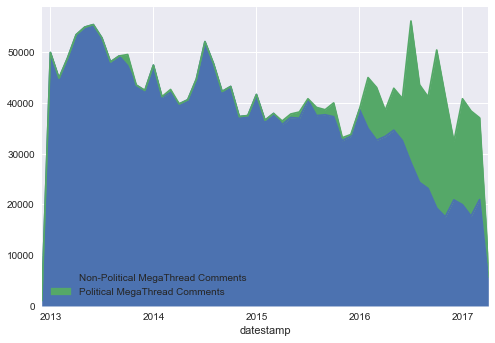

In [7]:
non_mega_df = comment_df.loc[comment_df.political_mega == False, ['datestamp', 'postid']].\
                      groupby(pd.Grouper(key='datestamp', freq='1M')).\
                      count().\
                      rename(columns={'postid': 'Non-Political MegaThread Comments'})

mega_df = comment_df.loc[comment_df.political_mega == True, ['datestamp', 'postid']].\
                     groupby(pd.Grouper(key='datestamp', freq='1M')).\
                     count().\
                     rename(columns={'postid': 'Political MegaThread Comments'})

non_mega_df.join(mega_df, how='outer').\
            fillna(0).\
            plot(kind='area')

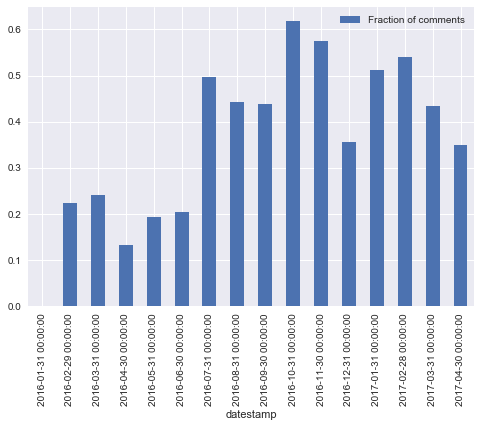

In [8]:
# Let's look at the proportion of comments per month in MegaThreads since 2016

non_mega_df = non_mega_df.rename(columns={'Non-Political MegaThread Comments': 'comments'})
mega_df = mega_df.rename(columns={'Political MegaThread Comments': 'comments'})

frac_df = mega_df.div((mega_df + non_mega_df)).\
                  fillna(0).\
                  reset_index().\
                  rename(columns={'comments': 'Fraction of comments'})

frac_df.loc[(frac_df.datestamp >= dt.datetime(2016, 1, 1)), :].\
        set_index('datestamp').\
        plot(kind='bar')

In [9]:
# Let's get the average number of comments per day in each of the threads during the target period.
# This actually requires us to turn to the comment data.
# The comment records for each thread log the number of comeents made on that thread
# *during its lifetime - that is,

non_mega_df = comment_df.loc[(comment_df.datestamp >= dt.datetime(2016, 7, 1)) &
                             (comment_df.datestamp < dt.datetime(2017, 3, 1)) &
                             (comment_df.political_mega == False), ['datestamp', 'postid']].\
                      groupby(pd.Grouper(key='datestamp', freq='1D')).\
                      count().\
                      rename(columns={'postid': 'Non-Political MegaThread Comments / Day'})

mega_df = comment_df.loc[(comment_df.datestamp >= dt.datetime(2016, 7, 1)) &
                         (comment_df.datestamp < dt.datetime(2017, 3, 1)) &
                         (comment_df.political_mega == True), ['datestamp', 'postid']].\
                     groupby(pd.Grouper(key='datestamp', freq='1D')).\
                     count().\
                     rename(columns={'postid': 'Political MegaThread Comments / Day'})

non_mega_df.join(mega_df, how='outer').\
            fillna(0).\
            describe()

,Non-Political MegaThread Comments / Day,Political MegaThread Comments / Day
count,243.000000,243.000000
mean,703.518519,713.238683
std,240.630325,599.907369
min,202.000000,34.000000
25%,526.000000,386.000000
50%,679.000000,570.000000
75%,855.000000,846.500000
max,1546.000000,4054.000000


### Discussion
By my count the comments in political MegaThreads took up more than half of the front-page's comment volume during four non-consecutive months, and came close to doing so during a fifth. Not quite as much as originally reported, but still very high. The daily averages match up nicely with sst's numbers, but the standard deviation for the political threads is quite high. 

## Fewer posts are being made

### Work

In [10]:
post_df = store['/mefi/postdata'].loc[:, ['postid', 'datestamp']]
post_df = post_df.loc[(post_df.datestamp > dt.datetime(1999, 1, 1)) &
                      (post_df.datestamp < dt.datetime(2017, 5, 1)), :]

print(post_df.shape)
post_df.head()

(165366, 2)


,postid,datestamp
0,19,1999-07-14 15:03:04.930
1,25,1999-07-15 09:37:51.770
2,26,1999-07-15 09:54:26.280
3,27,1999-07-15 09:57:54.160
4,33,1999-07-15 11:18:45.247


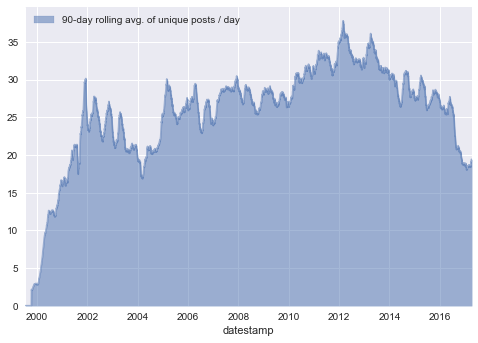

In [11]:
# getting and plotting the rolling average of the number of posts per day
# over a ninety day period
post_df.groupby(pd.Grouper(key='datestamp', freq='1D')).\
        count().\
        fillna(0).\
        rolling(90).\
        mean().\
        rename(columns={'postid': '90-day rolling avg. of unique posts / day'}).\
        plot(kind='area', stacked=False)


### Discussion

## Fewer users are commenting

### Work

In [12]:
# get comment data
comment_user_df = store['/mefi/commentdata'].loc[:, ['userid', 'datestamp']]
comment_user_df = comment_user_df.loc[(comment_user_df.datestamp > dt.datetime(1999, 1, 1)), :]

print(comment_user_df.shape)
comment_user_df.head()

(6927065, 2)


,userid,datestamp
0,1,1999-07-15 01:21:06.213
1,1,1999-07-15 10:00:12.850
2,16,1999-07-15 10:04:48.563
3,16,1999-07-15 10:54:36.160
4,1,1999-07-15 12:04:04.867


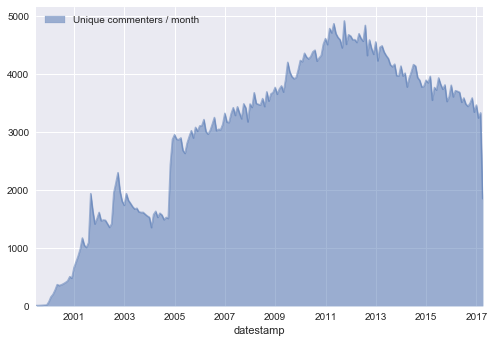

In [13]:
# getting and plotting the number of distinct commenters per month
comment_user_df.loc[comment_user_df.datestamp < dt.datetime(2017, 5, 1), :].\
                groupby(pd.Grouper(key='datestamp', freq='1M')).\
                agg(lambda x: x.nunique()).\
                fillna(0).\
                rename(columns={'userid': 'Unique commenters / month'}).\
                plot(kind='area', stacked=False)

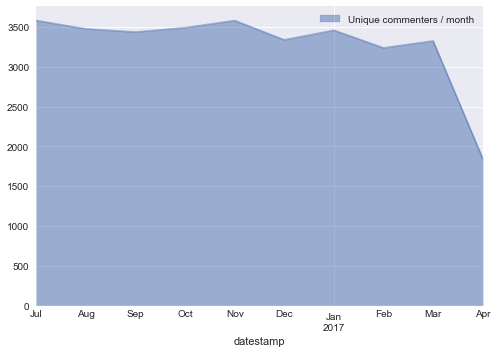

In [14]:
# Looking a little bit more clostely at the weird fall off at the end of April
comment_user_df.loc[(comment_user_df.datestamp > dt.datetime(2016, 7, 1)) &
                    (comment_user_df.datestamp < dt.datetime(2017, 5, 1)), :].\
                groupby(pd.Grouper(key='datestamp', freq='1M')).\
                agg(lambda x: x.nunique()).\
                fillna(0).\
                rename(columns={'userid': 'Unique commenters / month'}).\
                plot(kind='area', stacked=False)

In [15]:
# Looking at the weird drop-off as a table
comment_user_df.loc[(comment_user_df.datestamp > dt.datetime(2016, 7, 1)) &
                    (comment_user_df.datestamp < dt.datetime(2017, 5, 1)), :].\
                groupby(pd.Grouper(key='datestamp', freq='1M')).\
                agg(lambda x: x.nunique()).\
                fillna(0).\
                reset_index().\
                tail(5)

,datestamp,userid
5,2016-12-31,3338
6,2017-01-31,3459
7,2017-02-28,3237
8,2017-03-31,3325
9,2017-04-30,1847


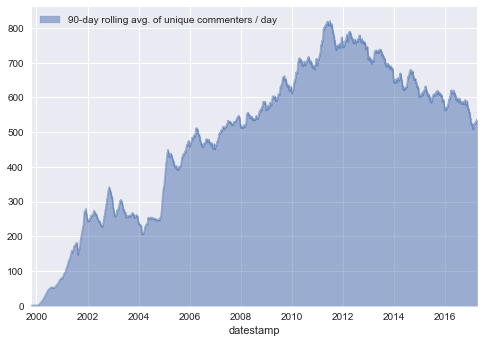

In [16]:
# Getting the rolling average of the number of commenters per ninety-day period
comment_user_df.loc[comment_user_df.datestamp < dt.datetime(2017, 5, 1), :].\
                groupby(pd.Grouper(key='datestamp', freq='1D')).\
                agg(lambda x: x.nunique()).\
                fillna(0).\
                rolling(90).\
                mean().\
                dropna().\
                rename(columns={'userid': '90-day rolling avg. of unique commenters / day'}).\
                plot(kind='area', stacked=False)

### Discussion
The number of distinct monthly front-page commenters has indeed been declining since 2012, though visuaully it seems hard to tie that to the election. The drop-off during April, 2017 has been surprisingly steep, and perhaps bears further investigation.